# 基于MindSpore实现一维线性回归

## 导入库和函数

In [1]:
import mindspore
import numpy as np #引入numpy科学计算库
import matplotlib.pyplot as plt #引入绘图库
np.random.seed(123) #随机数生成种子
#from sklearn.model_selection import train_test_split#从sklearn里面引出训练与测试集划分

import mindspore.nn as nn
import mindspore.ops as ops
from mindspore import Tensor
from mindspore import ParameterTuple, Parameter
from mindspore import dtype as mstype


## 自定义数据集生成函数

In [2]:
def get_data(num,w=2,b=3):
    for data in range(num):
        x=np.random.uniform(-10,10)
        noise=np.random.normal(0,1)
        y=x*w+b+noise
        yield np.array([x]).astype(np.float32),np.array([y]).astype(np.float32)


## 展示部分数据

In [3]:
eval_data=list(get_data(5))
x_eval_label,y_eval_label=zip(*eval_data)

eval_data


[(array([3.9293838], dtype=float32), array([9.906671], dtype=float32)),
 (array([1.0262954], dtype=float32), array([4.30715], dtype=float32)),
 (array([4.3893795], dtype=float32), array([12.100864], dtype=float32)),
 (array([3.6965947], dtype=float32), array([10.341672], dtype=float32)),
 (array([-0.38136196], dtype=float32), array([0.617976], dtype=float32))]

## 生成数据

In [4]:
from mindspore import dataset as ds

def create_dataset(num_data,batch_size=16,repeat_size=1):
    input_data=ds.GeneratorDataset(list(get_data(num_data)),column_names=['data','label'])
    input_data=input_data.batch(batch_size) # 设置数据批次
    input_data=input_data.repeat(repeat_size) # 设置数据重复次数
    return input_data

In [5]:
data_number=1600
batch_number=16
repeat_number=1

ds_train=create_dataset(data_number,batch_number,repeat_number)
print('数据集批次：',ds_train.get_dataset_size())
dict_datasets=next(ds_train.create_dict_iterator())

print(dict_datasets.keys())
print('X:',dict_datasets['data'].shape)
print('y:',dict_datasets['label'].shape)

数据集批次： 100
dict_keys(['data', 'label'])
X: (16, 1)
y: (16, 1)


## 定义一个简单的一维线性回归模型

In [6]:
from mindspore import nn
from mindspore.common.initializer import Normal

class LinearNet(nn.Cell):
    def __init__(self):
        super(LinearNet,self).__init__()
        # 定义一个线形层，同时初始化权重和偏置
        self.fc=nn.Dense(1,1,Normal(0.02),Normal(0.02),has_bias=True) 
    
    def construct(self,x):
        x=self.fc(x)
        return x



## 模型中的参数维度形状

In [7]:
net=LinearNet()
model_params=net.trainable_params()
for param in model_params:
    print(param,param.asnumpy())

Parameter (name=fc.weight, shape=(1, 1), dtype=Float32, requires_grad=True) [[-0.00267943]]
Parameter (name=fc.bias, shape=(1,), dtype=Float32, requires_grad=True) [-0.01840288]


## 模型的损失函数、优化器设置

In [8]:
net=LinearNet()
net_loss=nn.loss.MSELoss()
# 这里优化器的参数传入的为我们模型的训练参数，以及学习率等
opt=nn.Momentum(net.trainable_params(),learning_rate=0.005,momentum=0.9)
from mindspore import Model
model=Model(net,net_loss,opt)


## 定义一个函数画出模型拟合的直线以及真实的数据拟合直线的对比

In [9]:
import matplotlib.pyplot as plt
from mindspore import Tensor
import time

def plot_model_and_datasets(net, eval_data):
    weight = net.trainable_params()[0]
    bias = net.trainable_params()[1]
    x = np.arange(-10, 10, 0.1)
    y = x * Tensor(weight).asnumpy()[0][0] + Tensor(bias).asnumpy()[0]
    x1, y1 = zip(*eval_data)
    x_target = x
    y_target = x_target * 2 + 3

    plt.axis([-11, 11, -20, 25])
    plt.scatter(x1, y1, color="red", s=5)
    plt.plot(x, y, color="blue")
    plt.plot(x_target, y_target, color="green")
    plt.show()


## 回调函数，训练的过程中实时画出模型拟合的曲线

In [10]:
from IPython import display
from mindspore.train.callback import Callback

class ImageShowCallback(Callback):
    def __init__(self, net, eval_data):
        self.net = net
        self.eval_data = eval_data

    def step_end(self, run_context):
        plot_model_and_datasets(self.net, self.eval_data)
        # 清除打印内容，实现动态拟合效果
        display.clear_output(wait=True)


## 训练，观察效果

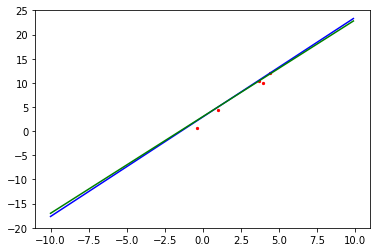

Parameter (name=fc.weight, shape=(1, 1), dtype=Float32, requires_grad=True) [[2.0583298]]
Parameter (name=fc.bias, shape=(1,), dtype=Float32, requires_grad=True) [2.9284358]


In [11]:
from mindspore.train.callback import LossMonitor

epoch = 1
imageshow_cb = ImageShowCallback(net, eval_data)
model.train(epoch, ds_train, callbacks=[imageshow_cb], dataset_sink_mode=False)

plot_model_and_datasets(net, eval_data)
for net_param in net.trainable_params():
    print(net_param, net_param.asnumpy())
